Training: 3699, Validation: 1310


Some weights of XLMRobertaModel were not initialized from the model checkpoint at l3cube-pune/hing-roberta and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10 - Training: 100%|██████████| 232/232 [00:37<00:00,  6.15it/s]



Epoch 1 Training Metrics:
loss: 0.1116
accuracy: 0.6932
f1: 0.5396
precision: 0.6129
recall: 0.4819


Epoch 1/10 - Validation: 100%|██████████| 82/82 [00:09<00:00,  8.68it/s]



Epoch 1 Validation Metrics:
loss: 0.0907
accuracy: 0.8260
f1: 0.7373
precision: 0.9639
recall: 0.5970


Epoch 2/10 - Training: 100%|██████████| 232/232 [00:37<00:00,  6.13it/s]



Epoch 2 Training Metrics:
loss: 0.0787
accuracy: 0.8137
f1: 0.7243
precision: 0.8088
recall: 0.6558


Epoch 2/10 - Validation: 100%|██████████| 82/82 [00:09<00:00,  8.68it/s]



Epoch 2 Validation Metrics:
loss: 0.0653
accuracy: 0.8519
f1: 0.8036
precision: 0.8783
recall: 0.7407


Epoch 3/10 - Training: 100%|██████████| 232/232 [00:48<00:00,  4.77it/s]



Epoch 3 Training Metrics:
loss: 0.0702
accuracy: 0.8405
f1: 0.7695
precision: 0.8347
recall: 0.7138


Epoch 3/10 - Validation: 100%|██████████| 82/82 [00:09<00:00,  8.61it/s]



Epoch 3 Validation Metrics:
loss: 0.0672
accuracy: 0.8542
f1: 0.8069
precision: 0.8808
recall: 0.7444


Epoch 4/10 - Training: 100%|██████████| 232/232 [00:48<00:00,  4.77it/s]



Epoch 4 Training Metrics:
loss: 0.0592
accuracy: 0.8721
f1: 0.8201
precision: 0.8631
recall: 0.7812


Epoch 4/10 - Validation: 100%|██████████| 82/82 [00:09<00:00,  8.62it/s]



Epoch 4 Validation Metrics:
loss: 0.0733
accuracy: 0.8366
f1: 0.7873
precision: 0.8426
recall: 0.7388


Epoch 5/10 - Training: 100%|██████████| 232/232 [00:59<00:00,  3.92it/s]



Epoch 5 Training Metrics:
loss: 0.0471
accuracy: 0.9008
f1: 0.8634
precision: 0.8875
recall: 0.8406


Epoch 5/10 - Validation: 100%|██████████| 82/82 [00:09<00:00,  8.61it/s]



Epoch 5 Validation Metrics:
loss: 0.1016
accuracy: 0.8481
f1: 0.8008
precision: 0.8639
recall: 0.7463


Epoch 6/10 - Training: 100%|██████████| 232/232 [00:59<00:00,  3.92it/s]



Epoch 6 Training Metrics:
loss: 0.0323
accuracy: 0.9384
f1: 0.9163
precision: 0.9286
recall: 0.9043


Epoch 6/10 - Validation: 100%|██████████| 82/82 [00:09<00:00,  8.57it/s]



Epoch 6 Validation Metrics:
loss: 0.1229
accuracy: 0.8458
f1: 0.8008
precision: 0.8494
recall: 0.7575
Early stopping after 6 epochs


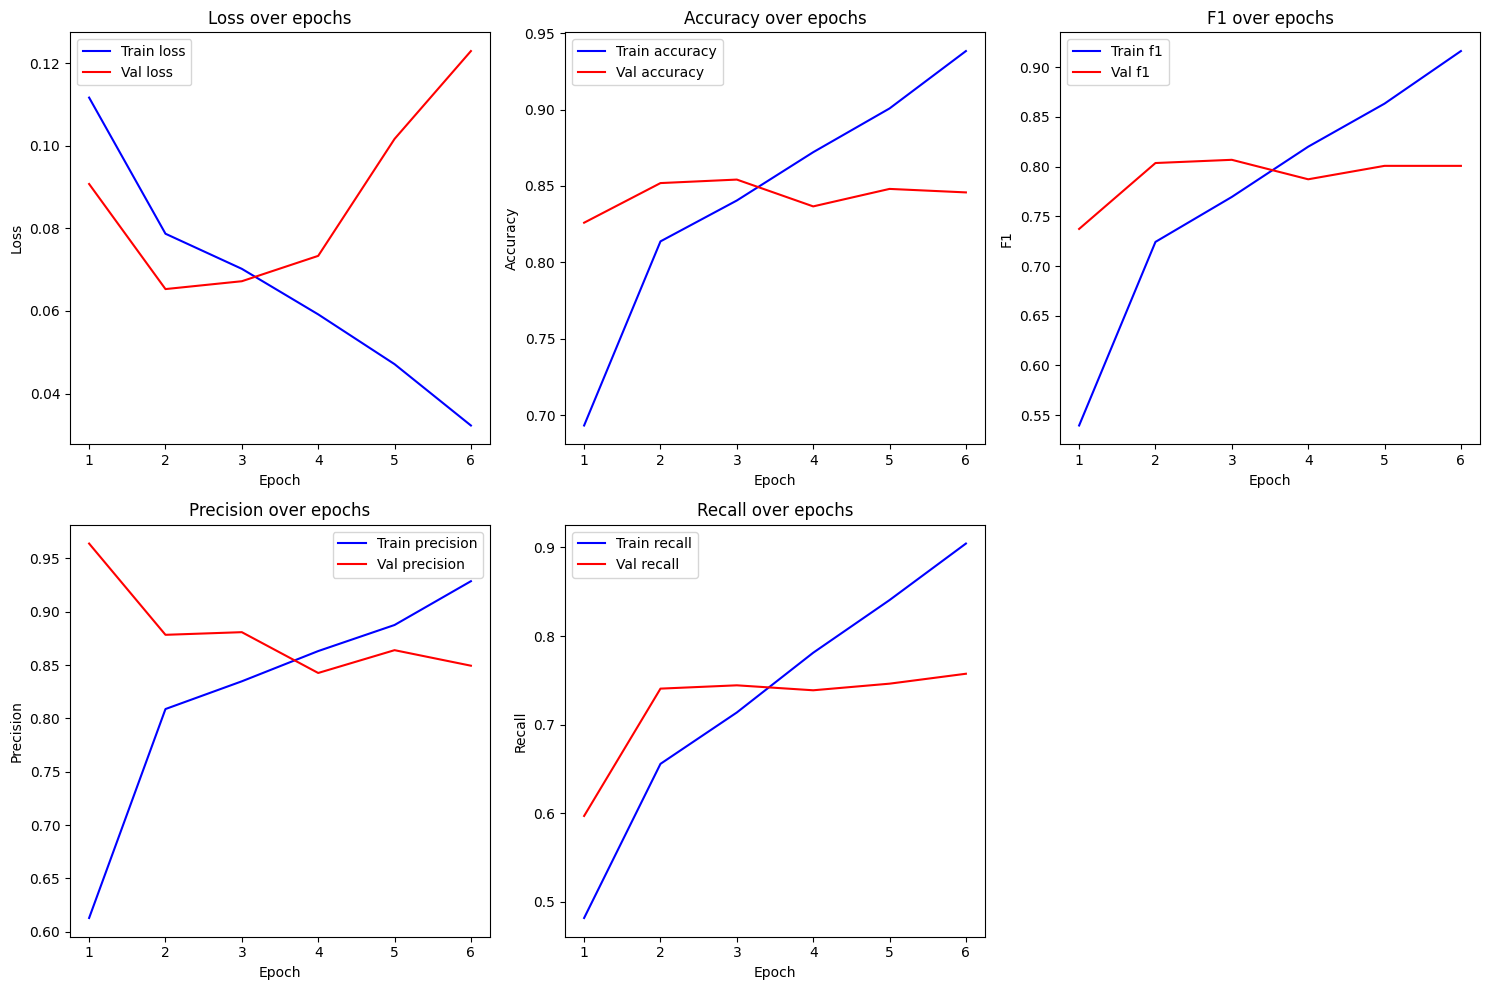

<ipython-input-3-2e2c98a448e1>:348: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pt')
Validating: 100%|██████████| 82/82 [00:09<00:00,  

Best threshold: 0.45 with F1: 0.8085

Validation Metrics (with optimal threshold):
loss: 0.0672
accuracy: 0.8481
f1: 0.8085
precision: 0.8350
recall: 0.7836


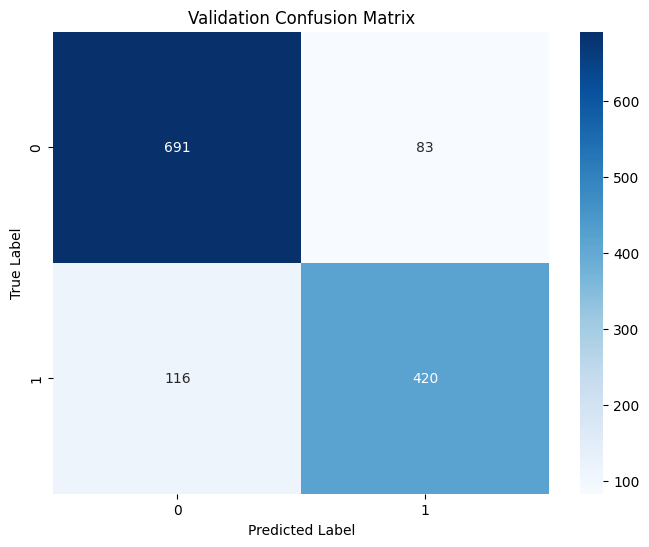

Validation predictions saved!


In [3]:
# [Cell 1] - Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seeds()

# [Cell 2] - Dataset Class with Augmentation
class HindiEnglishDataset(Dataset):
    def __init__(self, texts, labels, max_length=256, augment=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = AutoTokenizer.from_pretrained("l3cube-pune/hing-roberta")
        self.max_length = max_length
        self.augment = augment

    def __len__(self):
        return len(self.texts)

    def augment_text(self, text):
        words = text.split()
        if len(words) < 2:
            return text
        for i in range(len(words)):
            if random.random() < 0.1:  # 10% chance to mask a word
                words[i] = "[MASK]"
        return " ".join(words)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        if self.augment and random.random() < 0.5:  # 50% chance of augmentation
            text = self.augment_text(text)

        encoded = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(),
            'attention_mask': encoded['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# [Cell 3] - Model Definition with Enhanced Regularization
class XLMROBERTaClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):  # Increased dropout
        super().__init__()
        self.roberta = AutoModel.from_pretrained("l3cube-pune/hing-roberta")
        
        # Initially freeze all layers
        for param in self.roberta.parameters():
            param.requires_grad = False
        
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.LayerNorm(512),  # Added layer normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean=0.0, std=0.02)
                if module.bias is not None:
                    module.bias.data.zero_()

    def unfreeze_layers(self, layers_to_unfreeze):
        """Gradually unfreeze specified number of top layers"""
        for i in range(12 - layers_to_unfreeze, 12):
            for param in self.roberta.encoder.layer[i].parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # Using pooler output
        combined = self.dropout(pooled_output)
        return self.classifier(combined)

# [Cell 4] - Weighted Focal Loss and Metrics Visualizer
class WeightedFocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_with_logits = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        targets = targets.view(-1, 1)
        bce_loss = self.bce_with_logits(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

class MetricsVisualizer:
    def __init__(self):
        self.train_metrics = []
        self.val_metrics = []

    def add_metrics(self, train_metrics, val_metrics):
        self.train_metrics.append(train_metrics)
        self.val_metrics.append(val_metrics)

    def plot_metrics(self):
        epochs = range(1, len(self.train_metrics) + 1)
        metrics = ['loss', 'accuracy', 'f1', 'precision', 'recall']

        plt.figure(figsize=(15, 10))
        for i, metric in enumerate(metrics, 1):
            plt.subplot(2, 3, i)
            plt.plot(epochs, [m[metric] for m in self.train_metrics], 'b-', label=f'Train {metric}')
            plt.plot(epochs, [m[metric] for m in self.val_metrics], 'r-', label=f'Val {metric}')
            plt.title(f'{metric.capitalize()} over epochs')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.legend()
        plt.tight_layout()
        plt.show()

# [Cell 5] - Training Function with Gradual Unfreezing and OneCycleLR
def train_model(model, train_loader, val_loader, device, num_epochs=10):
    # Differential learning rates
    params = [
        {'params': model.classifier.parameters(), 'lr': 5e-4},
        {'params': model.roberta.encoder.layer[-4:].parameters(), 'lr': 5e-5, 'weight_decay': 0.1},
        {'params': model.roberta.encoder.layer[:-4].parameters(), 'lr': 1e-5, 'weight_decay': 0.1}
    ]
    optimizer = AdamW(params, weight_decay=0.1)  # Increased weight decay
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[5e-4, 5e-5, 1e-5],  # Max LRs for classifier, last 4 layers, earlier layers
        steps_per_epoch=len(train_loader),
        epochs=num_epochs,
        pct_start=0.1
    )
    criterion = WeightedFocalLoss()
    metrics_viz = MetricsVisualizer()

    best_val_f1 = 0
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        # Gradual unfreezing schedule
        if epoch == 0:
            model.unfreeze_layers(2)  # Unfreeze last 2 layers
        elif epoch == 2:
            model.unfreeze_layers(4)  # Unfreeze last 4 layers
        elif epoch == 4:
            model.unfreeze_layers(6)  # Unfreeze last 6 layers

        model.train()
        train_loss = 0
        train_preds, train_labels = [], []

        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).cpu().detach().numpy()
            train_preds.extend(preds.flatten())
            train_labels.extend(labels.cpu().numpy())

        train_metrics = {
            'loss': train_loss / len(train_loader),
            'accuracy': accuracy_score(train_labels, train_preds),
            'f1': f1_score(train_labels, train_preds, zero_division=0),
            'precision': precision_score(train_labels, train_preds, zero_division=0),
            'recall': recall_score(train_labels, train_preds, zero_division=0)
        }

        print(f"\nEpoch {epoch + 1} Training Metrics:")
        for metric, value in train_metrics.items():
            print(f"{metric}: {value:.4f}")

        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
                val_preds.extend(preds.flatten())
                val_labels.extend(labels.cpu().numpy())

        val_metrics = {
            'loss': val_loss / len(val_loader),
            'accuracy': accuracy_score(val_labels, val_preds),
            'f1': f1_score(val_labels, val_preds, zero_division=0),
            'precision': precision_score(val_labels, val_preds, zero_division=0),
            'recall': recall_score(val_labels, val_preds, zero_division=0)
        }

        print(f"\nEpoch {epoch + 1} Validation Metrics:")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value:.4f}")

        metrics_viz.add_metrics(train_metrics, val_metrics)

        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_f1': best_val_f1,
            }, 'best_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping after {epoch + 1} epochs')
                break

    metrics_viz.plot_metrics()
    return model

# [Cell 6] - Data Preparation
def prepare_data(train_path, val_path, batch_size=16):
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)

    print(f"Training: {len(train_df)}, Validation: {len(val_df)}")

    train_dataset = HindiEnglishDataset(train_df['clean_text'].values, train_df['labels'].values, augment=True)
    val_dataset = HindiEnglishDataset(val_df['clean_text'].values, val_df['labels'].values, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, train_df, val_df

# [Cell 7] - Model Evaluation with Threshold Optimization
def find_best_threshold(y_true, y_pred_probs):
    best_threshold, best_f1 = 0.5, 0
    thresholds = np.arange(0.1, 0.9, 0.05)
    for threshold in thresholds:
        y_pred = (y_pred_probs > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_threshold, best_f1 = threshold, f1
    print(f"Best threshold: {best_threshold:.2f} with F1: {best_f1:.4f}")
    return best_threshold

def evaluate_model(model, val_loader, device):
    model.eval()
    criterion = WeightedFocalLoss()
    val_loss = 0
    all_preds_probs, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds_probs.extend(probs.flatten())
            all_labels.extend(labels.cpu().numpy())

    best_thresh = find_best_threshold(all_labels, all_preds_probs)
    all_preds = (np.array(all_preds_probs) > best_thresh).astype(int)

    metrics = {
        'loss': val_loss / len(val_loader),
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0)
    }

    print("\nValidation Metrics (with optimal threshold):")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Validation Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return metrics, all_preds

# [Cell 8] - Main Execution
def main():
    train_path = "/kaggle/input/racial-hoax-large/Trainn.csv"
    val_path = "/kaggle/input/racial-hoax-large/validation.csv"

    train_loader, val_loader, train_df, val_df = prepare_data(train_path, val_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = XLMROBERTaClassifier().to(device)

    model = train_model(model, train_loader, val_loader, device, num_epochs=10)

    checkpoint = torch.load('best_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    val_metrics, val_preds = evaluate_model(model, val_loader, device)

    val_df = val_df.copy()
    val_df['predictions'] = val_preds
    val_df.to_csv("val_predictions.csv", index=False)
    print("Validation predictions saved!")

# [Cell 9] - Error Analysis
def analyze_errors(df, actual_col='labels', pred_col='predictions'):
    incorrect = df[df[actual_col] != df[pred_col]]
    print(f"Total incorrect predictions: {len(incorrect)}")
    display(incorrect.head(10))
    incorrect.to_csv("incorrect_predictions.csv", index=False)
    print("Incorrect predictions saved!")
    return incorrect

if __name__ == "__main__":
    main()